In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
import gc
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from sklearn.preprocessing import label_binarize
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score  
from functools import reduce
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

0


In [2]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, hash_size: int, type_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.hashlayer = nn.Linear(1*32*32, hash_size)
        self.typelayer = nn.Linear(1*32*32, type_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x_hash = self.hashlayer(x)
        x_type = self.typelayer(x)
        return x_hash, x_type

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
    
#https://github.com/marvis/pytorch-yolo2/blob/master/FocalLoss.py
#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py  
class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
#https://github.com/qianjinhao/circle-loss
class CircleLoss(nn.Module):
    def __init__(self, scale=32, margin=0.25, similarity='cos', **kwargs):
        super(CircleLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.similarity = similarity

    def forward(self, feats, labels):
        assert feats.size(0) == labels.size(0), \
            f"feats.size(0): {feats.size(0)} is not equal to labels.size(0): {labels.size(0)}"
        batch_size = feats.size(0)
        if self.similarity == 'dot':
            sim_mat = torch.matmul(feats, torch.t(feats))
        elif self.similarity == 'cos':
            feats = F.normalize(feats)
            sim_mat = feats.mm(feats.t())
        else:
            raise ValueError('This similarity is not implemented.')
        loss = list()
        for i in range(batch_size):
            pos_index = labels == labels[i]
            pos_index[i] = 0
            neg_index = labels != labels[i]
            pos_pair_ = sim_mat[i][pos_index]
            neg_pair_ = sim_mat[i][neg_index]

            alpha_p = torch.relu(-pos_pair_ + 1 + self.margin)
            alpha_n = torch.relu(neg_pair_ + self.margin)
            margin_p = 1 - self.margin
            margin_n = self.margin
            loss_p = torch.sum(torch.exp(-self.scale * alpha_p * (pos_pair_ - margin_p)))
            loss_n = torch.sum(torch.exp(self.scale * alpha_n * (neg_pair_ - margin_n)))
            loss.append(torch.log(1 + loss_p * loss_n))

        loss = sum(loss) / batch_size
        return loss    

#define loss function:pairwise loss            
class PairwiseLoss(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(PairwiseLoss, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])#[0:4555]
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    idx_4 = np.where( np.array(trY) == 4 ) #class 4
    idx_4 = list(idx_4[0])#[0:993]
    idx_sf.extend(idx_4)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    trQ_y, trP_y, trN_y = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        trQ_y.append(trY[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 4:
            idx_tmp = idx_4.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_4))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf), np.array(trQ_y), np.array(trP_y), np.array(trN_y)

In [3]:
#Dataset:  Fundus-DR https://www.kaggle.com/c/diabetic-retinopathy-detection/data
#Label:0 - No DR,1 - Mild,2 - Moderate,3 - Severe,4 - Proliferative DR
#generate dataset
image_dir = '/data/fjsdata/fundus/kaggle_DR/train/' 
trainset = pd.read_csv("/data/fjsdata/fundus/kaggle_DR/CBIR_train.csv" , sep=',')
#read train image with CV
trN, trI, trY = [],[],[]
for iname, itype in np.array(trainset).tolist():
    try:
        image_path = os.path.join(image_dir, iname+'.jpeg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))
        trN.append(iname)
        trI.append(img)
        trY.append(itype)  
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trainset.shape[0]))
    sys.stdout.flush()
print('The length of train set is %d'%len(trN))
#generate testset
testset = pd.read_csv("/data/fjsdata/fundus/kaggle_DR/CBIR_test.csv" , sep=',')
teN, teI, teY = [],[],[]
for iname, itype in np.array(testset).tolist():
    try:
        image_path = os.path.join(image_dir, iname+'.jpeg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))
        teN.append(iname)
        teI.append(img)
        teY.append(itype)  
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),testset.shape[0]))
    sys.stdout.flush()
print('The length of test set is %d'%len(teN))

24591 / 24591 The length of train set is 24591
10535 / 10535 The length of test set is 10535


In [37]:
#--------------------------------------------------------
#ATH-Triplet+CE
#--------------------------------------------------------
#sample  triplet labels
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = ATHNet(hash_size=36, type_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define cross-entropy loss

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
plot_tripletloss = []
for epoch in range(50):#iteration
    losses, hash_losses, class_loss = [], [], []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_hash, Q_type = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, P_type = model(P_batch.permute(0, 3, 1, 2))
        N_hash, N_type = model(N_batch.permute(0, 3, 1, 2))
        #loss,#F.log_softmax+F.nll_loss
        hash_loss = tl_loss(Q_hash,P_hash,N_hash)
        type_loss = ce_loss(Q_type,Q_y_batch) + ce_loss(P_type,P_y_batch) + ce_loss(N_type,N_y_batch) 
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
        hash_losses.append(hash_loss.item())
        class_loss.append(type_loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    plot_tripletloss.append(np.mean(hash_losses))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()

 2460 / 2460 : loss = 24.722332Eopch:     1 mean_loss = 21.477627
 2460 / 2460 : loss = 20.372761Eopch:     2 mean_loss = 21.418520
 2460 / 2460 : loss = 23.449907Eopch:     3 mean_loss = 21.439437
 2460 / 2460 : loss = 22.246849Eopch:     4 mean_loss = 21.286964
 2460 / 2460 : loss = 18.095695Eopch:     5 mean_loss = 21.052169
 2460 / 2460 : loss = 22.999689Eopch:     6 mean_loss = 20.723701
 2460 / 2460 : loss = 29.330463Eopch:     7 mean_loss = 20.255810
 2460 / 2460 : loss = 25.795618Eopch:     8 mean_loss = 19.829296
 2460 / 2460 : loss = 16.667467Eopch:     9 mean_loss = 19.149315
 2460 / 2460 : loss = 43.578205Eopch:    10 mean_loss = 18.563406
 2460 / 2460 : loss = 17.341036Eopch:    11 mean_loss = 17.943393
 2460 / 2460 : loss = 7.9539492Eopch:    12 mean_loss = 17.280882
 2460 / 2460 : loss = 7.5714229Eopch:    13 mean_loss = 16.678563
 2460 / 2460 : loss = 15.757919Eopch:    14 mean_loss = 16.064698
 2460 / 2460 : loss = 27.486027Eopch:    15 mean_loss = 15.507108
 2460 / 24

In [38]:
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize + 1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teY_prob = []
teF = [] 
num_batches = len(teY) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    teY_prob.extend(x_type.cpu().data.numpy().tolist())
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
#https://blog.csdn.net/hlang8160/article/details/78040311
#https://www.jianshu.com/p/7919ef304b19
#https://www.jianshu.com/p/c61ae11cc5f6
#https://www.cnblogs.com/yanshw/p/12691329.html
#TNR= TN / (FP + TN) ->low misdiagnosis rate->Specificity
#TPR=TP / (TP+ FN) -> low missed diagnosis rate->Sensitivity
#ROC: x axis = 1-TNR, y asis=TPR
#print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print (cm)
print ('Sensitivity(TPR) of No DR: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of Mild DR: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity(TPR) of Moderate DR: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity(TPR) of Severe DR: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity(TPR) of Proliferative DR: %.6f'%float(cm[4][4]/np.sum(cm[4])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) #for roc curve

 1053 / 1054 Completed buliding index in 2 seconds
mHR@10=0.672843, mAP@10=0.614157, mRR@10=0.865108
[[6641  132  651  240   79]
 [ 576   25   79   42   10]
 [1084   41  334   94   34]
 [ 146    6   59   43    7]
 [ 102    9   62   23   16]]
Sensitivity(TPR) of No DR: 0.857678
Sensitivity(TPR) of Mild DR: 0.034153
Sensitivity(TPR) of Moderate DR: 0.210460
Sensitivity(TPR) of Severe DR: 0.164751
Sensitivity(TPR) of Proliferative DR: 0.075472
AUC (Area Under Curve) of Micro: 0.882922


In [47]:
print(trainset['1'].value_counts())
print(testset['1'].value_counts())

0    18067
2     3705
1     1711
3      612
4      496
Name: 1, dtype: int64
0    7743
2    1587
1     732
3     261
4     212
Name: 1, dtype: int64


In [49]:
#figure 1 for problem introduction
for i in range(len(teY)):
    #if teY[i]==3 :#Severe DR
    if teN[i] in ['28901_right','19414_right']: 
        itype = teY[i]
        teVal = teF[i]
        image_path = os.path.join(image_dir, teN[i])
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')#hamming
        ranklist = heapq.nsmallest(5, map_item_score, key=map_item_score.get)
        for j in ranklist:
            print ('%s:%d-%s:%d-Distance:%.6f'%(teN[i],teY[i],trN[j],trY[j],map_item_score[j]))

28901_right:3-26349_right:0-Distance:0.224966
28901_right:3-2767_right:3-Distance:0.251558
28901_right:3-39496_right:0-Distance:0.261205
28901_right:3-145_right:0-Distance:0.270410
28901_right:3-12992_right:2-Distance:0.274095
19414_right:3-36691_right:3-Distance:0.150341
19414_right:3-34844_left:4-Distance:0.209438
19414_right:3-15985_left:0-Distance:0.215107
19414_right:3-5814_right:3-Distance:0.217504
19414_right:3-37020_left:1-Distance:0.218031


'\n28901_right:3-26349_right:0\n28901_right:3-2767_right:3\n28901_right:3-39496_right:0\n28901_right:3-145_right:0\n28901_right:3-12992_right:2\n\n19414_right:3-36691_right:3\n19414_right:3-34844_left:4\n19414_right:3-15985_left:0\n19414_right:3-5814_right:3\n19414_right:3-37020_left:1\n'

In [ ]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'dense' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0: 'No DR', 1: 'Mild DR', 2:'Moderate DR', 3:'Severe DR', 4:'Proliferative DR'}
#read image
root='/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/913024.jpg'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
#result = heatmap 
cv2.imwrite('iSee_cam.jpg', result)

Org data dimension is 36.Embedded data dimension is 2


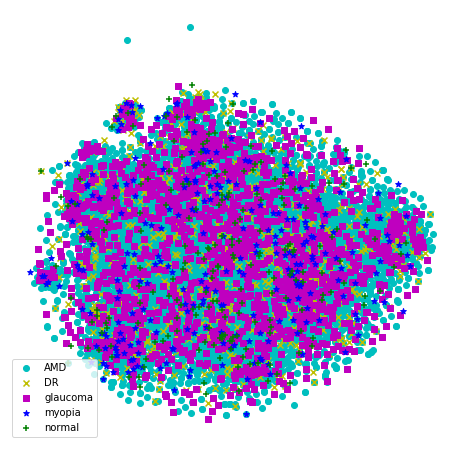

In [42]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g']
    marker = ['o','x','s','*','+']
    label = ['No DR','Mild DR','Moderate DR','Severe DR','Proliferative DR']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=label[i])
    plt.axis('off')
    plt.legend(loc='lower left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

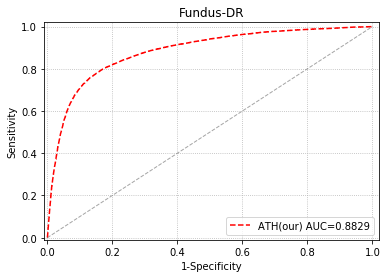

In [41]:
plt.plot(fpr_tce, tpr_tce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % auc_score)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('Fundus-DR')
plt.show()

In [18]:
#generate dataset
dataset = pd.read_csv("/data/fjsdata/fundus/kaggle_DR/trainLabels.csv" , sep=',')#load dataset
trainset, testset = [], []
#dataset = dataset[dataset['image'].contains('left')]
#tf = dataset['image'].str.contains('right')#right eye
#dataset = dataset[tf]
print (dataset.shape)
print (dataset['level'].value_counts())
ds =dataset[dataset['level']==0].sample(frac=1) #0,shuffle
testset.extend(np.array(ds).tolist()[0:int(0.3*len(ds))])
trainset.extend(np.array(ds).tolist()[int(0.3*len(ds)):])
ds =dataset[dataset['level']==1].sample(frac=1)#1
testset.extend(np.array(ds).tolist()[0:int(0.3*len(ds))])
trainset.extend(np.array(ds).tolist()[int(0.3*len(ds)):])
ds =dataset[dataset['level']==2].sample(frac=1)#2:
testset.extend(np.array(ds).tolist()[0:int(0.3*len(ds))])
trainset.extend(np.array(ds).tolist()[int(0.3*len(ds)):])
ds =dataset[dataset['level']==3].sample(frac=1)#3
testset.extend(np.array(ds).tolist()[0:int(0.3*len(ds))])
trainset.extend(np.array(ds).tolist()[int(0.3*len(ds)):])
ds =dataset[dataset['level']==4].sample(frac=1)#4
testset.extend(np.array(ds).tolist()[0:int(0.3*len(ds))])
trainset.extend(np.array(ds).tolist()[int(0.3*len(ds)):])
print (len(trainset))
print (len(testset))
pd.DataFrame(trainset).to_csv('/data/fjsdata/fundus/kaggle_DR/CBIR_train.csv',index=False)
pd.DataFrame(testset).to_csv('/data/fjsdata/fundus/kaggle_DR/CBIR_test.csv',index=False)

(35126, 2)
0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64
24591
10535
